In [113]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### 1. Data Generation

In [114]:
def generate_sdof_data(samples=1000, dt=0.01):
    """Generate and normalize synthetic SDOF data."""
    m, c, k = 1.0, 1.5, 200.0
    f = np.random.normal(0, 1, samples)
    
    x, v, a = np.zeros(samples), np.zeros(samples), np.zeros(samples)

    for i in range(1, samples):
        a[i] = (f[i] - c * v[i - 1] - k * x[i - 1]) / m
        v[i] = v[i - 1] + a[i] * dt
        x[i] = x[i - 1] + v[i] * dt

    X = np.stack([v, a, f], axis=1)
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(x.reshape(-1, 1)).flatten()

    return X, y

### 2. Model Definitions

In [115]:
class KAN(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, layers=[32, 32, 16]):
        super(KAN, self).__init__()
        self.network = nn.ModuleList()
        self.network.append(nn.Linear(input_dim, layers[0]))
        for i in range(1, len(layers)):
            self.network.append(nn.Linear(layers[i-1], layers[i]))
        self.network.append(nn.Linear(layers[-1], output_dim))

    def forward(self, x):
        for layer in self.network[:-1]:
            x = torch.relu(layer(x))
        return self.network[-1](x)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 250, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1000)  # Changed to match sequence length
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

class MLP(nn.Module):
    def __init__(self, input_features=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        return self.fc3(x)

### 3. Training Function

In [116]:
def train_model(model, X, y, epochs=2000, lr=1e-4):
    """Train model and return loss history."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    loss_history = []  # Track loss values
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X)
        if isinstance(model, CNN):
            outputs = outputs.view(-1, 1)
        elif outputs.dim() == 1:
            outputs = outputs.unsqueeze(1)
        
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())  # Store loss value
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
    return loss_history

def plot_loss_curves(loss_histories, title="Training Loss Curves"):
    """Plot training loss curves for all models."""
    plt.figure(figsize=(10, 6))
    
    for model_name, loss_history in loss_histories.items():
        plt.plot(loss_history, label=model_name)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    # plt.yscale('log')  # Use log scale for better visualization
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 4. Data Preparation Functions

In [117]:
def prepare_data():
    """Prepare all necessary data for training and evaluation"""
    X, y = generate_sdof_data()
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    # Prepare CNN data (batch_size, channels, sequence_length)
    X_cnn = X_tensor.transpose(0, 1).unsqueeze(0)
    # X_cnn = X_tensor.unsqueeze(0).permute(0, 2, 1)
    
    return X_tensor, y_tensor, X_cnn, y


### 5. Model Initialization

In [118]:
def initialize_models():
    kan = KAN()
    cnn = CNN()
    mlp = MLP()
    
    def initialize_weights(m):
        if isinstance(m, (nn.Linear, nn.Conv1d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    kan.apply(initialize_weights)
    cnn.apply(initialize_weights)
    mlp.apply(initialize_weights)
    
    return kan, cnn, mlp

### 6. Model Comparison Visualization

In [119]:
def plot_results(models, X_tensor, X_cnn, y, title_prefix="Model Predictions"):
    """Plot model predictions."""
    plt.figure(figsize=(15, 5))
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(1, 3, i)
        model.eval()
        with torch.no_grad():
            if name == 'CNN':
                predictions = model(X_cnn)
                y_pred = predictions.squeeze().numpy()
            else:  # KAN or MLP
                predictions = model(X_tensor)
                y_pred = predictions.squeeze().numpy()
            
            # Ensure y_pred is the right shape
            if y_pred.ndim == 0:
                y_pred = np.array([float(y_pred)])
            
            # Plot only first 200 points
            plot_range = slice(0, 200)
            plt.plot(y[plot_range], label='Ground Truth', alpha=0.7)
            plt.plot(y_pred[plot_range], label='Predicted', alpha=0.7)
            plt.title(f'{name} Prediction')
            plt.xlabel('Time Step')
            plt.ylabel('Displacement')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_models(models, X_tensor, X_cnn, y):
    """Evaluate model performance."""
    print("\nModel Performance Metrics:")
    print("-" * 50)
    
    results = {}
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            if name == 'CNN':
                predictions = model(X_cnn)
                y_pred = predictions.squeeze().numpy()
            else:
                predictions = model(X_tensor)
                y_pred = predictions.squeeze().numpy()
            
            # Ensure y_pred is the right shape
            if y_pred.ndim == 0:
                y_pred = np.array([float(y_pred)])
            
            # Make sure lengths match
            min_len = min(len(y_pred), len(y))
            y_pred = y_pred[:min_len]
            y_true = y[:min_len]
            
            mse = np.mean((y_true - y_pred) ** 2)
            mae = np.mean(np.abs(y_true - y_pred))
            r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
            
            results[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}
            
            print(f"\n{name} Metrics:")
            print(f"MSE: {mse:.6f}")
            print(f"MAE: {mae:.6f}")
            print(f"R²:  {r2:.6f}")
    
    return results

## Main execution

Preparing data...
Initializing models...

Training KAN...
Epoch [100/2000], Loss: 0.1356
Epoch [200/2000], Loss: 0.1005
Epoch [300/2000], Loss: 0.0618


Epoch [400/2000], Loss: 0.0274
Epoch [500/2000], Loss: 0.0095
Epoch [600/2000], Loss: 0.0039
Epoch [700/2000], Loss: 0.0024
Epoch [800/2000], Loss: 0.0018
Epoch [900/2000], Loss: 0.0014
Epoch [1000/2000], Loss: 0.0011
Epoch [1100/2000], Loss: 0.0009
Epoch [1200/2000], Loss: 0.0008
Epoch [1300/2000], Loss: 0.0007
Epoch [1400/2000], Loss: 0.0006
Epoch [1500/2000], Loss: 0.0005
Epoch [1600/2000], Loss: 0.0004
Epoch [1700/2000], Loss: 0.0004
Epoch [1800/2000], Loss: 0.0004
Epoch [1900/2000], Loss: 0.0003
Epoch [2000/2000], Loss: 0.0003

Training CNN...
Epoch [100/2000], Loss: 0.1493
Epoch [200/2000], Loss: 0.1435
Epoch [300/2000], Loss: 0.1379
Epoch [400/2000], Loss: 0.1326
Epoch [500/2000], Loss: 0.1274
Epoch [600/2000], Loss: 0.1224
Epoch [700/2000], Loss: 0.1175
Epoch [800/2000], Loss: 0.1129
Epoch [900/2000], Loss: 0.1085
Epoch [1000/2000], Loss: 0.1042
Epoch [1100/2000], Loss: 0.1001
Epoch [1200/2000], Loss: 0.0961
Epoch [1300/2000], Loss: 0.0923
Epoch [1400/2000], Loss: 0.0886
Epoch 

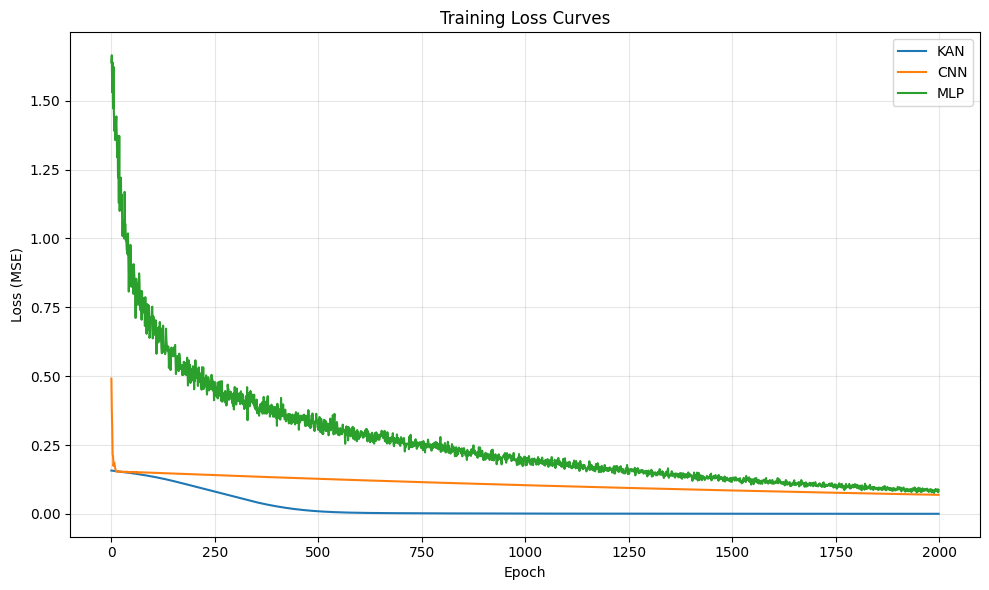


Plotting prediction results...


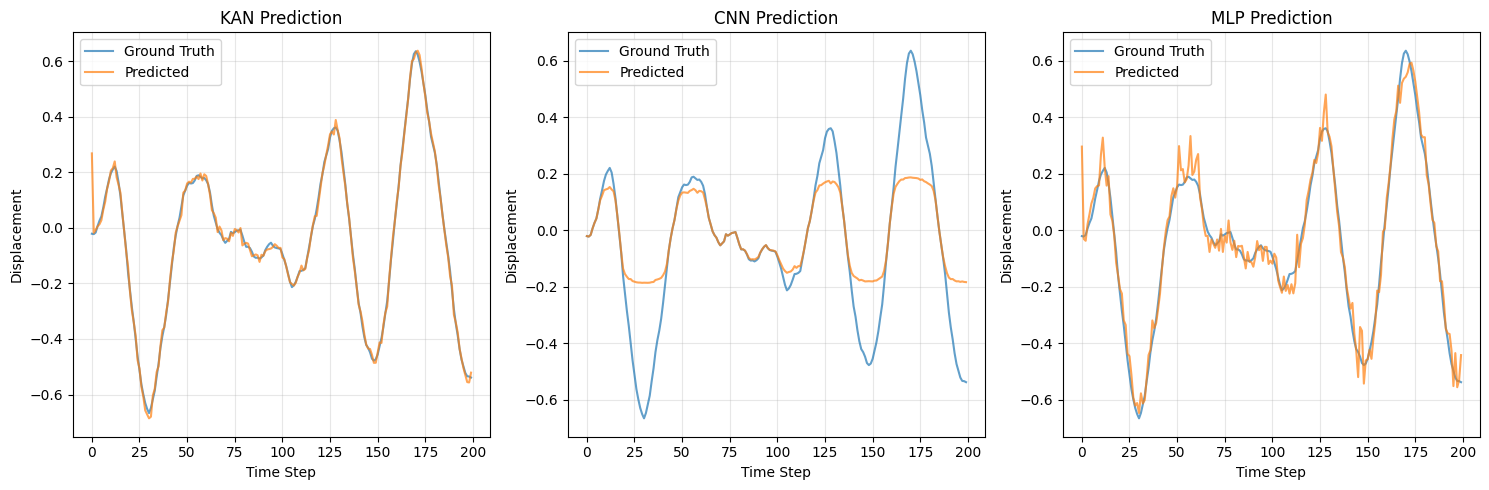


Evaluating models...

Model Performance Metrics:
--------------------------------------------------

KAN Metrics:
MSE: 0.000299
MAE: 0.011013
R²:  0.998066

CNN Metrics:
MSE: 0.069127
MAE: 0.175732
R²:  0.552597

MLP Metrics:
MSE: 0.003328
MAE: 0.042306
R²:  0.978462


In [120]:
if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    
    print("Preparing data...")
    X_tensor, y_tensor, X_cnn, y = prepare_data()
    
    print("Initializing models...")
    kan, cnn, mlp = initialize_models()
    
    # Dictionary to store loss histories
    loss_histories = {}
    
    print("\nTraining KAN...")
    loss_histories['KAN'] = train_model(kan, X_tensor, y_tensor)
    
    print("\nTraining CNN...")
    loss_histories['CNN'] = train_model(cnn, X_cnn, y_tensor)
    
    print("\nTraining MLP...")
    loss_histories['MLP'] = train_model(mlp, X_tensor, y_tensor)
    
    # Plot loss curves
    print("\nPlotting loss curves...")
    plot_loss_curves(loss_histories)
    
    models = {
        'KAN': kan,
        'CNN': cnn,
        'MLP': mlp
    }
    
    print("\nPlotting prediction results...")
    plot_results(models, X_tensor, X_cnn, y)
    
    print("\nEvaluating models...")
    results = evaluate_models(models, X_tensor, X_cnn, y)